# Twitter Sentiment Analysis Project

Group Members: Arvic Valdivieso, Halimah Khan


COMP 479-001 Machine Learning

Twitter sentiment analysis using Logistic Regression

# Preprocesing the data

In [2]:
# Import the necessary libraries
import nltk                                  # Python library for NLP
from nltk.corpus import twitter_samples      # sample Twitter dataset from NLTK
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Download the twitter samples
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

In [4]:
# download the stopwords for the process_tweet function
nltk.download('stopwords')

import re                                  # library for regular expression operations
import string                              # for string operations
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preparing the data by collecting the negative and positive samples

In [5]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# concatenate the lists, 1st part is the positive tweets followed by the negative
tweets = all_positive_tweets + all_negative_tweets

# make a numpy array representing labels of the tweets
labels = np.append(np.ones((len(all_positive_tweets))), np.zeros((len(all_negative_tweets))))


Split the data into Traning and Testing set (we aimed for a 70/30 split between training and testing partition)

In [22]:
# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[3500:] #in here are 1500
train_pos = all_positive_tweets[:3500]

test_neg = all_negative_tweets[3500:] #in here are 1500
train_neg = all_negative_tweets[:3500]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

We create an array of positive and negative labels

In [7]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

Print the shape train and test sets

In [8]:
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (7000, 1)
test_y.shape = (3000, 1)


# Preprocessing the text

Cleaning the tweets and stemming the words

In [9]:
def process_tweet(tweet):

    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')

    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)

    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)

    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)


    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)

    # tokenize tweets using TweetTokenizer
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
      # Check if the word is not a stopword and not a punctuation
        if (word not in stopwords_english and word not in string.punctuation):

            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [10]:
from collections import defaultdict

def build_freqs(tweets, ys):
    # Convert ys to a list
    yslist = np.squeeze(ys).tolist()

    # Initialize a defaultdict to store frequencies
    freqs = defaultdict(int)

    # Iterate through each tweet and its corresponding label
    for y, tweet in zip(yslist, tweets):
        # Process the tweet to get tokens
        tokens = process_tweet(tweet)
        # Update the frequencies for each token and sentiment pair
        freqs.update({(word, y): freqs[(word, y)] + 1 for word in tokens})

    return freqs

# DANIEL here

In [11]:
# DANIEL
# I added Word2Vec here (https://en.wikipedia.org/wiki/Word2vec)
from gensim.models import Word2Vec

# Creates a word2vec model from the given tweets.
# The model is saved in the "tweets.model" file.
def create_word2vec_model(tweets):
  clean_tweets = [process_tweet(tweet) for tweet in tweets]
  model = Word2Vec(clean_tweets)
  model.save('tweets.model')
  return model

# Converts a given tweet to a 100-value feature vector,
# using the given word2vec model.
def tweet_to_vector(tweet, model):
  vectors = [model.wv[word] for word in process_tweet(tweet) if word in model.wv.key_to_index]
  if vectors:
    return np.mean(vectors, axis=0)
  else:
    return np.zeros(model.vector_size)

In [12]:
# DANIEL
# feature vector tweets' conversion
word2vec_model = create_word2vec_model(train_x)

train_vectors = np.array([tweet_to_vector(tweet, word2vec_model) for tweet in train_x])
test_vectors = np.array([tweet_to_vector(tweet, word2vec_model) for tweet in test_x])

# data standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# train data
x_train_norm = scaler.fit_transform(train_vectors)
print(train_vectors.shape, train_y.shape)

#test data
x_test_norm = scaler.transform(test_vectors)
print(x_test_norm.shape, test_y.shape)

(7000, 100) (7000, 1)
(3000, 100) (3000, 1)


Balance Accuracy: 0.98


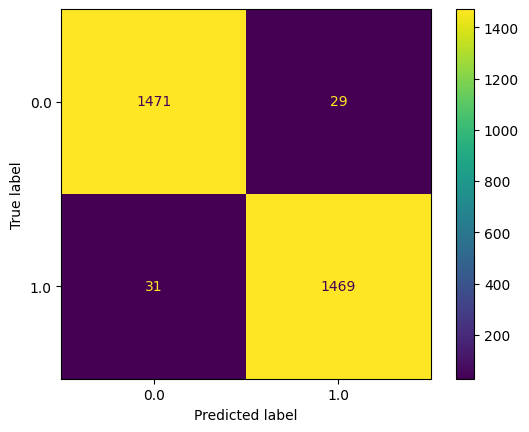

In [13]:
# DANIEL
# Simple logistic regressor
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=100000)
classifier.fit(x_train_norm, train_y.ravel())

y_predict = classifier.predict(x_test_norm)

from sklearn.metrics import balanced_accuracy_score
bacc = balanced_accuracy_score(test_y, y_predict)
print('Balance Accuracy:', bacc)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_y, y_predict, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

In [14]:
# DANIEL
# Possible next steps:
# 1. Understand and briefly explain word2vec (https://en.wikipedia.org/wiki/Word2vec)
# 2. Use PCA to reduce dimensionality (from 100 to <your choice here>). Look at notebook 2. DONE
# 3. Use other classifiers (KNN?, MLP?, please refer to notebooks 5 and 6) KNN IS DONE
# 4. Show the edge cases (i.e., tweets that were misclassified). Do they have something interesting?

# Reducing dimensionality PCA

In [15]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  # Reduce dimensionality to 50
x_train_pca = pca.fit_transform(x_train_norm)
x_test_pca = pca.transform(x_test_norm)


# Applying KNN

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


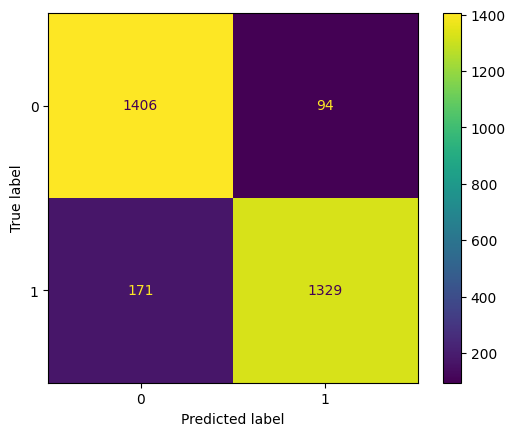

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

n = 3  # edit here to adjust the number of neighbors (k)

# Initialize KNN classifier
knn_classifier = KNeighborsClassifier(n)

# Train the classifier on the reduced-dimensional PCA data
knn_classifier.fit(x_train_pca, train_y)

# Predict using the trained classifier
y_predict_knn = knn_classifier.predict(x_test_pca)

# Plot confusion matrix for KNN
cm_knn = confusion_matrix(test_y, y_predict_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot()


In [17]:
# Balanced Accuracy
accuracy_knn = balanced_accuracy_score(test_y, y_predict_knn)
print('Balance Accuracy (KNN):', accuracy_knn)

Balance Accuracy (KNN): 0.9116666666666666


#Showing the edge cases

In [21]:
# Make predictions on the test data
y_predict = classifier.predict(x_test_norm)

# Compare predictions with true labels to identify misclassified tweets
misclassified_indices = [i for i, (pred, true) in enumerate(zip(y_predict, test_y)) if pred != true]

# Retrieve misclassified tweets and their corresponding true labels
misclassified_tweets = [test_x[i] for i in misclassified_indices]
true_labels = [test_y[i] for i in misclassified_indices]
predicted_labels = [y_predict[i] for i in misclassified_indices]

# Print or analyze the misclassified tweets along with their true and predicted labels
for tweet, true_label, predicted_label in zip(misclassified_tweets, true_labels, predicted_labels):
    print("Tweet:", tweet)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

Tweet: Dare I say that there is a video of me on our About Page - http://t.co/1nXM8mxmbu - talking infrared heating :-)
True Label: [1.]
Predicted Label: 0.0

Tweet: Please comment on what you think of what I wrote so far in the twitlonger :)
True Label: [1.]
Predicted Label: 0.0

Tweet: @75Susann 
how goes it : ) : P
True Label: [1.]
Predicted Label: 0.0

Tweet: I'm playing Brain Dots : ) #BrainDots
http://t.co/6TAEpQMBaN http://t.co/Le7bpWbMlO
True Label: [1.]
Predicted Label: 0.0

Tweet: Just watched sinister before I went to bed, wow I'm scared af now :-)
True Label: [1.]
Predicted Label: 0.0

Tweet: I made little @morganflying on Chibi maker :p http://t.co/n0BfUiXLpA
True Label: [1.]
Predicted Label: 0.0

Tweet: @claredolotina I love dogs moar naman haha I had one cat and she didn't love me as much huhu but she was cute :3

Tara barkin blends tho :D
True Label: [1.]
Predicted Label: 0.0

Tweet: @F41rygirl @paintingandbook You saying you want Lucy to be gone soon, Lisa!!? Oh that's